<a href="https://colab.research.google.com/github/DanieleBaiocco/IPCV_assignment2/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [190]:
from pathlib import Path
from PIL import Image
import PIL
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Callable, Optional
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import torchmetrics
from torchsummary import summary
import numpy as np
import random
import torchvision

In [101]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform: Callable[[PIL.Image.Image], Tensor]) -> None:
        super().__init__()
        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]
        tensor_img = self.transform(img).float()
        return tensor_img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []
        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path)
                labels.append(int(label))
        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [192]:
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PENSO CHE LA COSA MIGLIORE DA FARE SIA INIZIARE CON UN MODELLO MOLTO COMPLICATO CHE OVERFITTI SUL TRAINING DATA. A QUEL PUNTO INSERIRE DELLE REGULARIZATION TECNIQUES CHE MI FACCIANO ARRIVARE A UNA EFFECTIVE CAPACITY OTTIMALE.

In [77]:
!pip install mypy
# Simple mypy cell magic for Colab
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
from mypy import api

@register_cell_magic
def mypy(line, cell):
    for output in api.run(['-c', '\n' + cell] + line.split()):
        if output and not output.startswith('Success'):
            raise TypeError(output)
    get_ipython().run_cell(cell)

In [193]:
resize_size = 300
crop_size = 256

In [194]:
#%%mypy --ignore-missing-imports
def create_dataloader(split: str,
                      transform: Callable[[PIL.Image.Image],Tensor],
                      dataset_creation: Callable[[str, Callable[[PIL.Image.Image],Tensor]], Dataset],
                      batch_size: int,
                      shuffle: bool,
                      num_workers: int) -> DataLoader:
      dataset = dataset_creation(split, transform)
      return DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)

In [195]:
def starting_transform(resize_size, crop_size):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor()])

In [196]:
starting_trainloader =  create_dataloader('train', starting_transform(resize_size, crop_size), GroceryStoreDataset, batch_size = 64, shuffle = False, num_workers = 2)
def get_mean_and_std(loader):
    sum_red = 0.0
    sum_green = 0.0
    sum_blue = 0.0
    num_pixels = 0

    for images, _ in loader:
      sum_red += images[:, 0, :, :].sum().item()
      sum_green += images[:, 1, :, :].sum().item()
      sum_blue += images[:, 2, :, :].sum().item()

      # Count the number of pixels per channel
      num_pixels += images[:, 0, :, :].numel()

    mean_red = sum_red / num_pixels
    mean_green = sum_green / num_pixels
    mean_blue = sum_blue / num_pixels
        # Initialize variables to accumulate the squared difference from the mean
    sum_red_diff_sq = 0.0
    sum_green_diff_sq = 0.0
    sum_blue_diff_sq = 0.0

    for images, _ in loader:

        # Compute squared difference from mean for each channel
        sum_red_diff_sq += ((images[:, 0, :, :] - mean_red) ** 2).sum().item()
        sum_green_diff_sq += ((images[:, 1, :, :] - mean_green) ** 2).sum().item()
        sum_blue_diff_sq += ((images[:, 2, :, :] - mean_blue) ** 2).sum().item()

    # Calculate the standard deviation for each channel
    std_red = (sum_red_diff_sq / num_pixels) ** 0.5
    std_green = (sum_green_diff_sq / num_pixels) ** 0.5
    std_blue = (sum_blue_diff_sq / num_pixels) ** 0.5

    return [mean_red, mean_green, mean_blue], [std_red, std_green, std_blue]
mean_train, std_train = get_mean_and_std(starting_trainloader)

In [115]:
mean_train, std_train

([0.5414799105037342, 0.40250897678461944, 0.2514115906122959],
 [0.24257967399333805, 0.22068066844616727, 0.20375057548463663])

In [116]:
def data_augmentation_transform(crop_size, mean, std):
    return transforms.Compose([transforms.RandomResizedCrop(crop_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])
def base_transform(resize_size, crop_size, mean, std):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])

In [117]:
basecnf = {'train_transform': data_augmentation_transform(crop_size, mean_train, std_train),
           'test_transform': base_transform(resize_size, crop_size, mean_train, std_train),
                      'batch_size': 64,
                      'num_workers': 2}

In [118]:
train_dataloader = create_dataloader('train', basecnf['train_transform'], GroceryStoreDataset, basecnf['batch_size'], True, basecnf['num_workers'])
val_dataloader = create_dataloader('val', basecnf['test_transform'], GroceryStoreDataset, basecnf['batch_size'], False, basecnf['num_workers'])
test_dataloader = create_dataloader('test', basecnf['test_transform'], GroceryStoreDataset, basecnf['batch_size'], False, basecnf['num_workers'])

In [72]:
import  matplotlib.pyplot as plt

In [73]:
food_dict = {
    0: "Apple",
    1: "Avocado",
    2: "Banana",
    3: "Kiwi",
    4: "Lemon",
    5: "Lime",
    6: "Mango",
    7: "Melon",
    8: "Nectarine",
    9: "Orange",
    10: "Papaya",
    11: "Passion-Fruit",
    12: "Peach",
    13: "Pear",
    14: "Pineapple",
    15: "Plum",
    16: "Pomegranate",
    17: "Red-Grapefruit",
    18: "Satsumas",
    19: "Juice",
    20: "Milk",
    21: "Oatghurt",
    22: "Oat-Milk",
    23: "Sour-Cream",
    24: "Sour-Milk",
    25: "Soyghurt",
    26: "Soy-Milk",
    27: "Yoghurt",
    28: "Asparagus",
    29: "Aubergine",
    30: "Cabbage",
    31: "Carrots",
    32: "Cucumber",
    33: "Garlic",
    34: "Ginger",
    35: "Leek",
    36: "Mushroom",
    37: "Onion",
    38: "Pepper",
    39: "Potato",
    40: "Red-Beet",
    41: "Tomato",
    42: "Zucchini"
}

In [123]:
for train_data, target in train_dataloader:
  for img, label in zip(train_data, target):
        print(f'Label of the image: {food_dict[label.item()]}')
        img = img * 255.0  # Convert to byte to ensure the values are in the range [0, 255]
        # Change dimensions from (C, H, W) to (H, W, C) if necessary
        img = img.permute(1, 2, 0)
        plt.imshow(img)
        plt.show()
  break

Label of the image: Melon


TypeError: only integer tensors of a single element can be converted to an index

In [124]:
class SqueezeDims(torch.nn.Module):
    def forward(self, x):
        return x.squeeze()

class GroceryStoreModel(torch.nn.Module):
    def __init__(self, nonlin_fn: Callable[[], torch.nn.Module],
                 nor_fn: Callable[[int], torch.nn.Module],
                 dropout_head,
                 dropout_fe,
                 stem_convs_fn: Callable[[int, Callable[[], torch.nn.Module], Callable[[int], torch.nn.Module]], torch.nn.Sequential],
                 stem_output_channels: int,
                 num_stages: int,
                 stage_fn: Callable[[int, Callable[[], torch.nn.Module], Callable[[int], torch.nn.Module]], torch.nn.Sequential],
                 num_classes: int):
        super(GroceryStoreModel, self).__init__()
        self.stem = torch.nn.Sequential(
            stem_convs_fn(stem_output_channels, nonlin_fn, nor_fn, dropout_fe),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stages = torch.nn.ModuleList()
        in_channels = stem_output_channels
        for _ in range(num_stages):
            stage = stage_fn(in_channels, nonlin_fn, nor_fn, dropout_fe)
            self.stages.append(stage)
            in_channels *= 2
        self.head = torch.nn.Sequential(
          torch.nn.AdaptiveAvgPool2d((1, 1)),
          SqueezeDims(),
          torch.nn.Dropout(dropout_head),
          torch.nn.Linear(in_channels, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = self.head(x)
        return x

In [125]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels , out_channels , kernel_size , stride , padding, normalization_layer: torch.nn.Module, activation_layer: torch.nn.Module, dropout_rate: int):
        super(ConvBlock,self).__init__()

        # 2d convolution
        self.conv2d = torch.nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding  )

        # batchnorm
        self.batchnorm2d = normalization_layer

        # relu layer
        self.relu = activation_layer

        self.dropout_rate = dropout_rate

    def forward(self,x):
        x = self.conv2d(x)
        x = self.batchnorm2d(x)
        x = self.relu(x)
        if self.dropout_rate>0:
          x = torch.nn.Dropout(self.dropout_rate)(x)
        return x

In [126]:
class InceptionBlock(torch.nn.Module):
    '''

    building block of inception-v1 architecture. creates following 4 branches and concatenate them
    (a) branch1: 1x1 conv
    (b) branch2: 1x1 conv followed by 3x3 conv
    (c) branch3: 1x1 conv followed by 5x5 conv
    (d) branch4: Maxpool2d followed by 1x1 conv

        Note:
            1. output and input feature map height and width should remain the same. Only the channel output should change. eg. 28x28x192 -> 28x28x256
            2. To generate same height and width of output feature map as the input feature map, following should be padding for
                * 1x1 conv : p=0
                * 3x3 conv : p=1
                * 5x5 conv : p=2


    Args:
       in_channels (int) : # of input channels
       out_1x1 (int) : number of output channels for branch 1
       red_3x3 (int) : reduced 3x3 referring to output channels of 1x1 conv just before 3x3 in branch2
       out_3x3 (int) : number of output channels for branch 2
       red_5x5 (int) : reduced 5x5 referring to output channels of 1x1 conv just before 5x5 in branch3
       out_5x5 (int) : number of output channels for branch 3
       out_1x1_pooling (int) : number of output channels for branch 4

    Attributes:
        concatenated feature maps from all 4 branches constituiting output of Inception module.

    '''
    def __init__(self , in_channels, out_channels, normalization_fn, activation_fn, dropout_rate):
        super(InceptionBlock,self).__init__()
        out_1x1 = out_channels // 4
        red_3x3 = out_1x1 // 2
        out_3x3 = out_1x1
        red_5x5 = out_1x1 // 2
        out_5x5 = out_1x1
        out_1x1_pooling = out_1x1

        # branch1 : k=1,s=1,p=0
        self.branch1 = ConvBlock(in_channels,out_1x1,1,1,0, normalization_fn(out_1x1), activation_fn(), dropout_rate)

        # branch2 : k=1,s=1,p=0 -> k=3,s=1,p=1
        self.branch2 = torch.nn.Sequential(ConvBlock(in_channels,red_3x3,1,1,0, normalization_fn(red_3x3), activation_fn(), dropout_rate),ConvBlock(red_3x3,out_3x3,3,1,1,normalization_fn(out_3x3), activation_fn(), dropout_rate))

        # branch3 : k=1,s=1,p=0 -> k=5,s=1,p=2
        self.branch3 = torch.nn.Sequential(ConvBlock(in_channels,red_5x5,1,1,0,normalization_fn(red_5x5), activation_fn(), dropout_rate),ConvBlock(red_5x5,out_5x5,5,1,2,normalization_fn(out_5x5), activation_fn(), dropout_rate))

        # branch4 : pool(k=3,s=1,p=1) -> k=1,s=1,p=0
        self.branch4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3,stride=1,padding=1),ConvBlock(in_channels,out_1x1_pooling,1,1,0,normalization_fn(out_1x1_pooling), activation_fn(), dropout_rate))


    def forward(self,x):

        # concatenation from dim=1 as dim=0 represents batchsize
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],dim=1)


In [127]:
def inception_stage(in_channels: int, activation_fn: Callable[[], torch.nn.Module], normalization_fn: Callable[[int], torch.nn.Module], dropout_rate:float = 0.0) -> torch.nn.Sequential:
    out_channels = in_channels * 2
    return torch.nn.Sequential(
        InceptionBlock(in_channels, out_channels, normalization_fn, activation_fn,dropout_rate),
        InceptionBlock(out_channels, out_channels, normalization_fn, activation_fn,dropout_rate),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

In [128]:
# vorrei fare anche un paragone col numero di parametri risultanti dalla rete e salvare tutto in una tabella.
# tipo comparando il risultato delle performance tra modello con fclayers e modello con global avg poooling INSIEME anche a  una comparazione sul numero di parametri
# usati.
#from thop import profile
#flops, params = profile(model, inputs=(inputs,))
def block(in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int,
          normalization_layer: torch.nn.Module, activation_layer: torch.nn.Module, dropout_rate: int) -> torch.nn.Sequential:
    layers = [
        torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        normalization_layer,
        activation_layer
    ]
    if dropout_rate > 0:
        layers.append(torch.nn.Dropout(dropout_rate))
    return torch.nn.Sequential(*layers)

def stem_convs1(out_channels: int, activation_fn: Callable[[], torch.nn.Module], normalization_fn: Callable[[int], torch.nn.Module], dropout_rate:float = 0.0) -> torch.nn.Sequential:
    return torch.nn.Sequential(
        block(3, out_channels, 3, 2, 1, normalization_fn(out_channels), activation_fn(),dropout_rate),
        block(out_channels, out_channels, 3, 1, 1, normalization_fn(out_channels), activation_fn(),dropout_rate),
        block(out_channels, out_channels, 3, 1, 1, normalization_fn(out_channels), activation_fn(),dropout_rate)
    )

def stem_convs2(out_channels: int, activation_fn: Callable[[], torch.nn.Module], normalization_fn: Callable[[int], torch.nn.Module], dropout_rate:float = 0.0) -> torch.nn.Sequential:
    return block(3, out_channels, 7, 2, 1, normalization_fn(out_channels), activation_fn(),dropout_rate)

def stage_fn1(in_channels: int, activation_fn: Callable[[], torch.nn.Module], normalization_fn: Callable[[int], torch.nn.Module], dropout_rate:float = 0.0) -> torch.nn.Sequential:
    out_channels = in_channels * 2
    return torch.nn.Sequential(
        block(in_channels, out_channels, 3, 1, 1, normalization_fn(out_channels), activation_fn(),dropout_rate),
        block(out_channels, out_channels, 3, 1, 1, normalization_fn(out_channels), activation_fn() ,dropout_rate),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

def stage_fn2(in_channels: int, activation_fn: Callable[[], torch.nn.Module], normalization_fn: Callable[[int], torch.nn.Module], dropout_rate:float = 0.0) -> torch.nn.Sequential:
    out_channels = in_channels * 2
    return torch.nn.Sequential(
        block(in_channels, out_channels, 5, 1, 2, normalization_fn(out_channels), activation_fn(),dropout_rate),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

In [169]:
model = GroceryStoreModel(
    nonlin_fn=lambda: torch.nn.LeakyReLU(),
    nor_fn=lambda channels: torch.nn.BatchNorm2d(channels),
    dropout_head = 0.3,
    dropout_fe = 0.1,
    stem_convs_fn=stem_convs1,
    stem_output_channels=64,
    num_stages=4,
    stage_fn=inception_stage,
    num_classes=43
)

In [170]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GroceryStoreModel(
  (stem): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.1, inplace=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.1, inplace=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation

In [171]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
           Dropout-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
       BatchNorm2d-6         [-1, 64, 128, 128]             128
         LeakyReLU-7         [-1, 64, 128, 128]               0
           Dropout-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,928
      BatchNorm2d-10         [-1, 64, 128, 128]             128
        LeakyReLU-11         [-1, 64, 128, 128]               0
          Dropout-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 32,

In [172]:
def perform_epoch(dataloader, epoch, num_epochs, metric, device, is_train = False, optimizer=None, scheduler=None):
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if is_train:
            optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        if is_train:
          loss.backward()
          optimizer.step()
          scheduler.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        metric.update(preds, targets.to(device))
    epoch_loss = running_loss / len(dataloader)
    metric_value = metric.compute().item()
    return epoch_loss, metric_value

In [180]:
def train(model, num_epochs, criterion, opt, train_dl, val_dl, num_classes, earlystop_patience, weights_path, device):
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.001, steps_per_epoch=len(train_dl), epochs=num_epochs)
    train_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    val_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    best_val_acc = 0.0
    epochs_without_improvement = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
         model.train()
         train_acc_fn.reset()
         loss, acc = perform_epoch(train_dl, epoch, num_epochs, train_acc_fn, device, is_train=True, optimizer = opt, scheduler = scheduler)
         train_losses.append(loss)
         train_accuracies.append(acc)
         model.eval()
         val_acc_fn.reset()
         with torch.no_grad():
            val_loss, val_acc= perform_epoch(val_dl, epoch, num_epochs, val_acc_fn, device)
         val_losses.append(val_loss)
         val_accuracies.append(val_acc.item())
         print(f"Epoch {epoch+1}/{num_epochs}")
         print(f"Train Loss: {loss:.4f} Train Accuracy: {acc:.4f}")
         print(f"Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}")
         if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"{weights_path}/model{best_val_acc:3f}.pt")
            print(f"Saved best model weights with validation accuracy: {best_val_acc:.4f}")
         else:
              epochs_without_improvement += 1
              if epochs_without_improvement >= earlystop_patience:
                  print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
                  break
    history = {
      'train_losses': train_losses,
      'train_accuracies': train_accuracies,
      'val_losses': val_losses,
      'val_accuracies': val_accuracies
    }
    return history

In [137]:
import os

# Define the path of the directory you want to create
directory = 'saved_weights/'

# Use os.makedirs() to create the directory and any necessary parent directories
os.makedirs(directory, exist_ok=True)

# Check if the directory was created
if os.path.exists(directory):
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Failed to create directory '{directory}'.")

Directory 'saved_weights/' created successfully.


In [174]:
checkpoint = torch.load('saved_weights/best_model.pt')

# Load state_dict into model
model.load_state_dict(checkpoint)


<All keys matched successfully>

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [175]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
num_epochs = 100
history = train(model,
      num_epochs = num_epochs,
      criterion = criterion,
      opt = optimizer,
      train_dl = train_dataloader,
      val_dl = val_dataloader,
      num_classes = 43,
      earlystop_patience = 40,
      weights_path = 'saved_weights',
      device=device)

Epoch 1/100: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 1/100
Train Loss: 1.5348 Train Accuracy: 0.5545
Val Loss: 2.1152 Val Accuracy: 0.4020
Saved best model weights with validation accuracy: 0.4020


Epoch 2/100: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Epoch 2/100
Train Loss: 1.4489 Train Accuracy: 0.5799
Val Loss: 2.0430 Val Accuracy: 0.3986


Epoch 3/100: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 3/100
Train Loss: 1.4202 Train Accuracy: 0.5852
Val Loss: 2.0539 Val Accuracy: 0.3885


Epoch 4/100: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Epoch 4/100
Train Loss: 1.3923 Train Accuracy: 0.6008
Val Loss: 2.0438 Val Accuracy: 0.3986


Epoch 5/100: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 5/100
Train Loss: 1.3665 Train Accuracy: 0.6068
Val Loss: 1.9410 Val Accuracy: 0.4257
Saved best model weights with validation accuracy: 0.4257


Epoch 6/100: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 6/100
Train Loss: 1.2931 Train Accuracy: 0.6133
Val Loss: 2.0026 Val Accuracy: 0.3986


Epoch 7/100: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Epoch 7/100
Train Loss: 1.2823 Train Accuracy: 0.6106
Val Loss: 2.0397 Val Accuracy: 0.3986


Epoch 8/100: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 8/100
Train Loss: 1.2399 Train Accuracy: 0.6178
Val Loss: 1.9309 Val Accuracy: 0.4257


Epoch 9/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 9/100
Train Loss: 1.2022 Train Accuracy: 0.6292
Val Loss: 1.9938 Val Accuracy: 0.4054


Epoch 10/100: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 10/100
Train Loss: 1.1572 Train Accuracy: 0.6265
Val Loss: 1.9297 Val Accuracy: 0.4054


Epoch 11/100: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 11/100
Train Loss: 1.1162 Train Accuracy: 0.6500
Val Loss: 1.8907 Val Accuracy: 0.4054


Epoch 12/100: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 12/100
Train Loss: 1.1255 Train Accuracy: 0.6473
Val Loss: 1.9962 Val Accuracy: 0.4155


Epoch 13/100: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 13/100
Train Loss: 1.0639 Train Accuracy: 0.6708
Val Loss: 1.8637 Val Accuracy: 0.4392
Saved best model weights with validation accuracy: 0.4392


Epoch 14/100: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 14/100
Train Loss: 1.0575 Train Accuracy: 0.6682
Val Loss: 1.8587 Val Accuracy: 0.4257


Epoch 15/100: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 15/100
Train Loss: 1.0244 Train Accuracy: 0.6807
Val Loss: 2.0054 Val Accuracy: 0.3750


Epoch 16/100: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 16/100
Train Loss: 1.0006 Train Accuracy: 0.6780
Val Loss: 1.8987 Val Accuracy: 0.4358


Epoch 17/100: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 17/100
Train Loss: 0.9939 Train Accuracy: 0.6830
Val Loss: 1.9075 Val Accuracy: 0.4358


Epoch 18/100: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 18/100
Train Loss: 0.9133 Train Accuracy: 0.7189
Val Loss: 1.8590 Val Accuracy: 0.4358


Epoch 19/100: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 19/100
Train Loss: 0.8825 Train Accuracy: 0.7182
Val Loss: 2.1397 Val Accuracy: 0.3784


Epoch 20/100: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 20/100
Train Loss: 0.8924 Train Accuracy: 0.7182
Val Loss: 2.0302 Val Accuracy: 0.4392


Epoch 21/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 21/100
Train Loss: 0.8390 Train Accuracy: 0.7303
Val Loss: 2.0097 Val Accuracy: 0.3818


Epoch 22/100: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 22/100
Train Loss: 0.8396 Train Accuracy: 0.7367
Val Loss: 2.2484 Val Accuracy: 0.4088


Epoch 23/100: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch 23/100
Train Loss: 0.8769 Train Accuracy: 0.7208
Val Loss: 2.0664 Val Accuracy: 0.4054


Epoch 24/100: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 24/100
Train Loss: 0.8748 Train Accuracy: 0.7231
Val Loss: 2.2032 Val Accuracy: 0.3750


Epoch 25/100: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 25/100
Train Loss: 0.8187 Train Accuracy: 0.7280
Val Loss: 1.9410 Val Accuracy: 0.4291


Epoch 26/100: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 26/100
Train Loss: 0.7748 Train Accuracy: 0.7473
Val Loss: 1.9606 Val Accuracy: 0.4054


Epoch 27/100: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 27/100
Train Loss: 0.7858 Train Accuracy: 0.7530
Val Loss: 1.8787 Val Accuracy: 0.4595
Saved best model weights with validation accuracy: 0.4595


Epoch 28/100: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch 28/100
Train Loss: 0.7887 Train Accuracy: 0.7553
Val Loss: 2.1665 Val Accuracy: 0.4426


Epoch 29/100: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 29/100
Train Loss: 0.7595 Train Accuracy: 0.7576
Val Loss: 2.0465 Val Accuracy: 0.4054


Epoch 30/100: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 30/100
Train Loss: 0.7121 Train Accuracy: 0.7561
Val Loss: 1.9191 Val Accuracy: 0.4459


Epoch 31/100: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 31/100
Train Loss: 0.6929 Train Accuracy: 0.7875
Val Loss: 1.9800 Val Accuracy: 0.4392


Epoch 32/100: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 32/100
Train Loss: 0.7634 Train Accuracy: 0.7598
Val Loss: 2.0815 Val Accuracy: 0.4223


Epoch 33/100: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 33/100
Train Loss: 0.6868 Train Accuracy: 0.7814
Val Loss: 1.9954 Val Accuracy: 0.4797
Saved best model weights with validation accuracy: 0.4797


Epoch 34/100: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Epoch 34/100
Train Loss: 0.6667 Train Accuracy: 0.7879
Val Loss: 2.0981 Val Accuracy: 0.4459


Epoch 35/100: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 35/100
Train Loss: 0.7067 Train Accuracy: 0.7867
Val Loss: 2.0640 Val Accuracy: 0.4595


Epoch 36/100: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch 36/100
Train Loss: 0.6499 Train Accuracy: 0.8008
Val Loss: 1.6937 Val Accuracy: 0.4730


Epoch 37/100: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 37/100
Train Loss: 0.5720 Train Accuracy: 0.8167
Val Loss: 2.0321 Val Accuracy: 0.4730


Epoch 38/100: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 38/100
Train Loss: 0.5318 Train Accuracy: 0.8337
Val Loss: 2.0587 Val Accuracy: 0.4291


Epoch 39/100: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 39/100
Train Loss: 0.6094 Train Accuracy: 0.8030
Val Loss: 1.8292 Val Accuracy: 0.4966
Saved best model weights with validation accuracy: 0.4966


Epoch 40/100: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch 40/100
Train Loss: 0.6054 Train Accuracy: 0.8178
Val Loss: 1.7819 Val Accuracy: 0.5439
Saved best model weights with validation accuracy: 0.5439


Epoch 41/100: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 41/100
Train Loss: 0.5708 Train Accuracy: 0.8182
Val Loss: 1.8311 Val Accuracy: 0.4966


Epoch 42/100: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 42/100
Train Loss: 0.5505 Train Accuracy: 0.8216
Val Loss: 1.9378 Val Accuracy: 0.4932


Epoch 43/100: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 43/100
Train Loss: 0.5462 Train Accuracy: 0.8364
Val Loss: 2.0962 Val Accuracy: 0.4696


Epoch 44/100: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 44/100
Train Loss: 0.5119 Train Accuracy: 0.8337
Val Loss: 1.7980 Val Accuracy: 0.5372


Epoch 45/100: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 45/100
Train Loss: 0.5007 Train Accuracy: 0.8492
Val Loss: 2.1690 Val Accuracy: 0.4189


Epoch 46/100: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 46/100
Train Loss: 0.5879 Train Accuracy: 0.8314
Val Loss: 2.0818 Val Accuracy: 0.4662


Epoch 47/100: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 47/100
Train Loss: 0.4997 Train Accuracy: 0.8477
Val Loss: 2.0757 Val Accuracy: 0.4899


Epoch 48/100: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 48/100
Train Loss: 0.4652 Train Accuracy: 0.8534
Val Loss: 1.9496 Val Accuracy: 0.4899


Epoch 49/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 49/100
Train Loss: 0.4995 Train Accuracy: 0.8439
Val Loss: 2.1364 Val Accuracy: 0.4426


Epoch 50/100: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 50/100
Train Loss: 0.4731 Train Accuracy: 0.8508
Val Loss: 2.0186 Val Accuracy: 0.4662


Epoch 51/100: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 51/100
Train Loss: 0.4832 Train Accuracy: 0.8545
Val Loss: 1.9113 Val Accuracy: 0.4966


Epoch 52/100: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 52/100
Train Loss: 0.4271 Train Accuracy: 0.8720
Val Loss: 1.8019 Val Accuracy: 0.5236


Epoch 53/100: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 53/100
Train Loss: 0.4614 Train Accuracy: 0.8636
Val Loss: 1.8159 Val Accuracy: 0.5135


Epoch 54/100: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 54/100
Train Loss: 0.4297 Train Accuracy: 0.8697
Val Loss: 1.7326 Val Accuracy: 0.5068


Epoch 55/100: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 55/100
Train Loss: 0.4342 Train Accuracy: 0.8686
Val Loss: 1.7486 Val Accuracy: 0.5405


Epoch 56/100: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch 56/100
Train Loss: 0.3958 Train Accuracy: 0.8754
Val Loss: 1.8989 Val Accuracy: 0.5135


Epoch 57/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 57/100
Train Loss: 0.3720 Train Accuracy: 0.8943
Val Loss: 1.7944 Val Accuracy: 0.5101


Epoch 58/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 58/100
Train Loss: 0.4508 Train Accuracy: 0.8629
Val Loss: 1.8071 Val Accuracy: 0.5236


Epoch 59/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 59/100
Train Loss: 0.3711 Train Accuracy: 0.8875
Val Loss: 1.7905 Val Accuracy: 0.5439


Epoch 60/100: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 60/100
Train Loss: 0.3760 Train Accuracy: 0.8848
Val Loss: 1.6993 Val Accuracy: 0.5507
Saved best model weights with validation accuracy: 0.5507


Epoch 61/100: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 61/100
Train Loss: 0.3570 Train Accuracy: 0.8909
Val Loss: 1.7274 Val Accuracy: 0.5203


Epoch 62/100: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 62/100
Train Loss: 0.3428 Train Accuracy: 0.8890
Val Loss: 1.8364 Val Accuracy: 0.5338


Epoch 63/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 63/100
Train Loss: 0.3429 Train Accuracy: 0.8996
Val Loss: 1.7950 Val Accuracy: 0.5270


Epoch 64/100: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 64/100
Train Loss: 0.3457 Train Accuracy: 0.9034
Val Loss: 1.6464 Val Accuracy: 0.5541
Saved best model weights with validation accuracy: 0.5541


Epoch 65/100: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 65/100
Train Loss: 0.3567 Train Accuracy: 0.8890
Val Loss: 1.8509 Val Accuracy: 0.4966


Epoch 66/100: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 66/100
Train Loss: 0.3376 Train Accuracy: 0.8989
Val Loss: 1.8338 Val Accuracy: 0.5270


Epoch 67/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 67/100
Train Loss: 0.3341 Train Accuracy: 0.8973
Val Loss: 1.9213 Val Accuracy: 0.5101


Epoch 68/100: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Epoch 68/100
Train Loss: 0.2903 Train Accuracy: 0.9178
Val Loss: 1.7824 Val Accuracy: 0.5236


Epoch 69/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 69/100
Train Loss: 0.3164 Train Accuracy: 0.9049
Val Loss: 1.8515 Val Accuracy: 0.5101


Epoch 70/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 70/100
Train Loss: 0.3036 Train Accuracy: 0.9136
Val Loss: 1.8244 Val Accuracy: 0.5169


Epoch 71/100: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 71/100
Train Loss: 0.3275 Train Accuracy: 0.9038
Val Loss: 1.8353 Val Accuracy: 0.5135


Epoch 72/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 72/100
Train Loss: 0.3002 Train Accuracy: 0.9129
Val Loss: 1.7964 Val Accuracy: 0.5270


Epoch 73/100: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 73/100
Train Loss: 0.3041 Train Accuracy: 0.9174
Val Loss: 1.6926 Val Accuracy: 0.5541


Epoch 74/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 74/100
Train Loss: 0.2945 Train Accuracy: 0.9152
Val Loss: 1.7289 Val Accuracy: 0.5574
Saved best model weights with validation accuracy: 0.5574


Epoch 75/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 75/100
Train Loss: 0.2558 Train Accuracy: 0.9299
Val Loss: 1.7088 Val Accuracy: 0.5642
Saved best model weights with validation accuracy: 0.5642


Epoch 76/100: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 76/100
Train Loss: 0.2555 Train Accuracy: 0.9288
Val Loss: 1.7825 Val Accuracy: 0.5372


Epoch 77/100: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 77/100
Train Loss: 0.2677 Train Accuracy: 0.9348
Val Loss: 1.6756 Val Accuracy: 0.5845
Saved best model weights with validation accuracy: 0.5845


Epoch 78/100: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 78/100
Train Loss: 0.2520 Train Accuracy: 0.9250
Val Loss: 1.7707 Val Accuracy: 0.5541


Epoch 79/100: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 79/100
Train Loss: 0.2760 Train Accuracy: 0.9269
Val Loss: 1.6498 Val Accuracy: 0.5811


Epoch 80/100: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 80/100
Train Loss: 0.2652 Train Accuracy: 0.9250
Val Loss: 1.7291 Val Accuracy: 0.5236


Epoch 81/100: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 81/100
Train Loss: 0.2630 Train Accuracy: 0.9326
Val Loss: 1.6460 Val Accuracy: 0.5507


Epoch 82/100: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 82/100
Train Loss: 0.2295 Train Accuracy: 0.9337
Val Loss: 1.8372 Val Accuracy: 0.5101


Epoch 83/100: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 83/100
Train Loss: 0.2462 Train Accuracy: 0.9288
Val Loss: 1.7935 Val Accuracy: 0.5236


Epoch 84/100: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 84/100
Train Loss: 0.2419 Train Accuracy: 0.9330
Val Loss: 1.6739 Val Accuracy: 0.5642


Epoch 85/100: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 85/100
Train Loss: 0.2403 Train Accuracy: 0.9326
Val Loss: 1.6211 Val Accuracy: 0.5676


Epoch 86/100: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 86/100
Train Loss: 0.2419 Train Accuracy: 0.9330
Val Loss: 1.6152 Val Accuracy: 0.5507


Epoch 87/100: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 87/100
Train Loss: 0.2351 Train Accuracy: 0.9307
Val Loss: 1.7668 Val Accuracy: 0.5372


Epoch 88/100: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 88/100
Train Loss: 0.2028 Train Accuracy: 0.9424
Val Loss: 1.7908 Val Accuracy: 0.5304


Epoch 89/100: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 89/100
Train Loss: 0.2206 Train Accuracy: 0.9398
Val Loss: 1.6793 Val Accuracy: 0.5642


Epoch 90/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 90/100
Train Loss: 0.2246 Train Accuracy: 0.9394
Val Loss: 1.6569 Val Accuracy: 0.5405


Epoch 91/100: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Epoch 91/100
Train Loss: 0.2074 Train Accuracy: 0.9413
Val Loss: 1.7098 Val Accuracy: 0.5574


Epoch 92/100: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 92/100
Train Loss: 0.2351 Train Accuracy: 0.9390
Val Loss: 1.6902 Val Accuracy: 0.5642


Epoch 93/100: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 93/100
Train Loss: 0.2331 Train Accuracy: 0.9288
Val Loss: 1.7036 Val Accuracy: 0.5338


Epoch 94/100: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 94/100
Train Loss: 0.2072 Train Accuracy: 0.9424
Val Loss: 1.7357 Val Accuracy: 0.5541


Epoch 95/100: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 95/100
Train Loss: 0.1831 Train Accuracy: 0.9470
Val Loss: 1.7034 Val Accuracy: 0.5405


Epoch 96/100: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 96/100
Train Loss: 0.2119 Train Accuracy: 0.9402
Val Loss: 1.6416 Val Accuracy: 0.5608


Epoch 97/100: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 97/100
Train Loss: 0.2083 Train Accuracy: 0.9417
Val Loss: 1.6464 Val Accuracy: 0.5507


Epoch 98/100: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 98/100
Train Loss: 0.2190 Train Accuracy: 0.9375
Val Loss: 1.7591 Val Accuracy: 0.5473


Epoch 99/100: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 99/100
Train Loss: 0.2379 Train Accuracy: 0.9398
Val Loss: 1.7284 Val Accuracy: 0.5338


Epoch 100/100: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

Epoch 100/100
Train Loss: 0.1927 Train Accuracy: 0.9527
Val Loss: 1.7796 Val Accuracy: 0.5439


In [188]:
def plot_training_history(history):
    train_losses = history['train_losses']
    train_accuracies = history['train_accuracies']
    val_losses = history['val_losses']
    val_accuracies = history['val_accuracies']

    epochs = range(1, len(train_losses) + 1)


    # Plotting losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    train_accuracies = [acc.item() for acc in train_accuracies]
    val_accuracies = [acc.item() for acc in val_accuracies]

    best_epoch = val_accuracies.index(max(val_accuracies)) + 1
    best_val_acc = max(val_accuracies)

    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Validation Accuracy ({best_val_acc:.4f})')
    plt.text(best_epoch + 1, best_val_acc - 0.02, f'Peak: Epoch {best_epoch}: {best_val_acc:.3f}', color='g', fontsize=10, va='center', ha='left')
    plt.scatter(best_epoch, best_val_acc, color='g', zorder=5)

    plt.legend()

    plt.tight_layout()
    plt.show()

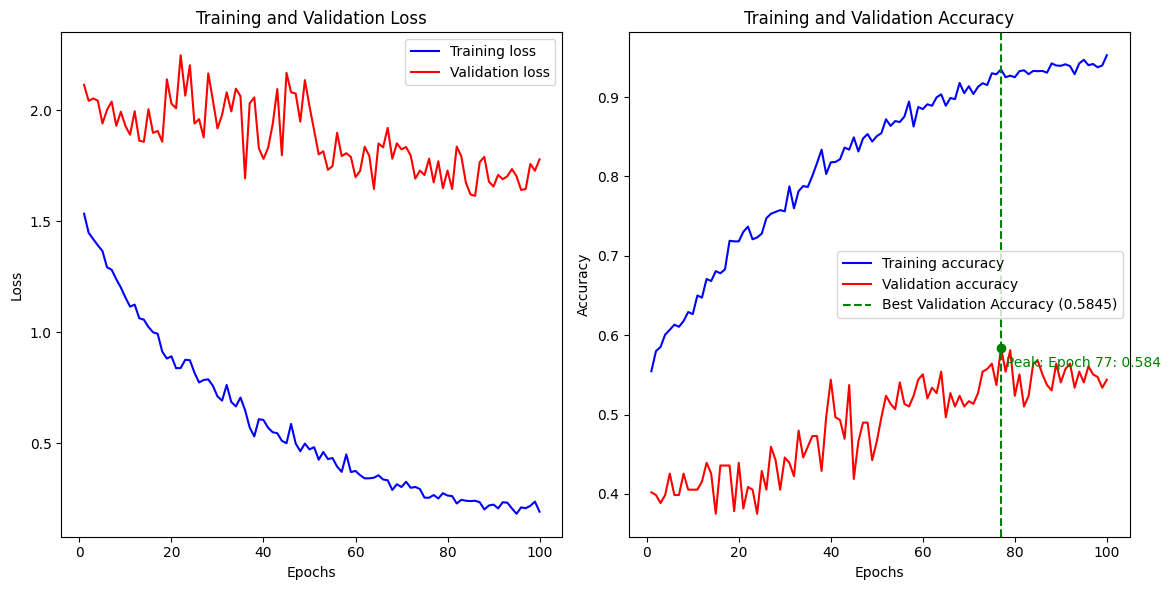

In [189]:
plot_training_history(history)